In [1]:
# Bibliotecas python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
%matplotlib inline

# Função para calcular moda.
from scipy import stats

# Formatação dos gráficos
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend

In [2]:
# Configurando o tema do gráfico
myrcs = {"axes.titleweight": "bold", "lines.markersize": 9.0, "lines.linewidth": 2.0,}
sns.set (style="whitegrid", font_scale=1.25, rc=myrcs)

# Linhas exibidas por padrão nos dataframes
pd.options.display.min_rows = 20

In [3]:
#Configurações
# A1 - com switch HW, não podendo aumentar/diminuir número de switches SW (número máximo de SW = 1)
# A2 - com switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 2)
# A3 - com switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 3)
# A4 - com switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 4)
# A5 - com switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 5)
# B - sem switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 5)
# D - com switch HW, não podendo aumentar/diminuir número de switches SW (número de SW fixo em 5)

#Novos gráficos com média (intervalo estavel):
#CDF das bandas e duracao dos trafegos (do arquivo iperfs) --------VERIFICAR--------
#Eixo x -> maxSW por experimento
#Eixo y -> valor
#Hue -> cargas

# Parâmetros que variam nesta simulação
seeds = [1,2,3,4,5,6]
cargas = ["50hosts", "100hosts", "150hosts"]
experimentos = ["a1","a2","a3","a4","a5"]

# Tempo total de simulação
t_sim = 2000

In [4]:
# Função para ler os arquivos de log
def mymode (series):
    return stats.mode (series)[0]

agg_map = {'SwAtivosAntes' : mymode, 'SwAtivosDepois' : np.mean, 'AvgCPULoad' : np.mean}

def read_df_decisao ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-logDecisaoSwitchesSW.log", sep='\s+', index_col=["TimeSec"])
                df_sed.append (df)
            #df_carga.append (pd.concat (df_sed).groupby (["TimeSec"]).agg (agg_map))
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Carga","Experimento","Seed","TimeSec"], copy=False)
    return df_read

def read_df_statistics ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-statistics.log", sep='\s+', index_col=["TimeSec"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Carga","Experimento","Seed","TimeSec"], copy=False)
    return df_read

def read_df_hw ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-switch-stats-hw.log", sep='\s+', index_col=["TimeSec"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Carga","Experimento","Seed","TimeSec"], copy=False)
    return df_read

def read_df_sw ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            if(experimento[0] == "a"):
                numSW = int(experimento[1])
            df_sw = []
            for sw in range(1,numSW+1):
                df_sed = []
                for seed in seeds:
                    df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-switch-stats-sw"+str(sw)+".log", sep='\s+', index_col=["TimeSec"])
                    df_sed.append (df)
                df_sw.append(pd.concat (df_sed, keys=seeds))
            df_exp.append(pd.concat(df_sw, keys=range(1,numSW+1)))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Carga","Experimento","NumSW","Seed","TimeSec"], copy=False)
    return df_read

def read_df_ping ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-pingHW.log", sep='\s+', index_col=["seq"])
                df['Switch'] = "HW"
                df_sed.append (df)
                df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-pingSW.log", sep='\s+', index_col=["seq"])
                df['Switch'] = "SW"
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Carga","Experimento","Seed","TimeSec"], copy=False)
    return df_read

def read_df_iperfs ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-iperfs.log", sep='\s+')
                df_sed.append (df)
            #df_carga.append (pd.concat (df_sed).groupby (["TimeSec"]).agg (agg_map))
            df_exp.append(pd.concat (df_sed))
        df_carga.append (pd.concat (df_exp))
    df_read = pd.concat (df_carga, keys=cargas, copy=False)
    return df_read


In [5]:
df_sw = read_df_sw()
df_sw = df_sw.loc[(df_sw["LoaKbps"]!=0)]
df_sw["%drop"] = df_sw["LoaDrps"]/(df_sw["Packets"]+df_sw["LoaDrps"])
df_sw

LoaKbps  LoaUsag  Packets  \
Carga    Experimento NumSW Seed TimeSec                                 
50hosts  a1          1     1    2.0        9683.328        1      799   
                                3.0       38111.360        5     3143   
                                4.0       66418.112        9     5477   
                                5.0       97866.016       13     8070   
                                6.0      140071.456       19    11550   
                                7.0      176879.936       24    14585   
                                8.0      204495.392       27    16862   
                                9.0      226980.704       30    18716   
                                10.0     252849.728       34    20849   
                                11.0      30300.928        4     2499   
...                                             ...      ...      ...   
150hosts a5          5     5    112.0    414729.088       55    34196   
                                113.0    408673.744       54    33697   
                                114.0    399763.136       53    32962   
                                115.0    392195.264       52    32338   
                                116.0    385197.408       51    31761   
                                117.0    376534.544       50    31047   
                                118.0    370215.856       49    30526   
                                119.0    361244.608       48    29786   
                                120.0    350935.808       47    28936   
                                121.0    315352.256       42    26002   

                                         DlyUsec  LoaDrps  MetDrps  TabDrps  \
Carga    Experimento NumSW Seed TimeSec                                       
50hosts  a1          1     1    2.0          426        0        0        0   
                                3.0          571        0        0        0   
                                4.0          655        0        0        0   
                                5.0          695        0        0        0   
                                6.0          748        0        0        0   
                                7.0          794        0        0        0   
                                8.0          799        0        0        0   
                                9.0          799        0        0        0   
                                10.0         799        0        0        0   
                                11.0         799        0        0        0   
...                                          ...      ...      ...      ...   
150hosts a5          5     5    112.0       1300        0        0        0   
                                113.0       1300        0        0        0   
                                114.0       1300        0        0        0   
                                115.0       1300        0        0        0   
                                116.0       1300        0        0        0   
                                117.0       1300        0        0        0   
                                118.0       1300        0        0        0   
                                119.0       1300        0        0        0   
                                120.0       1300        0        0        0   
                                121.0       1300        0        0        0   

                                         FloMods  MetMods  GroMods  ...  \
Carga    Experimento NumSW Seed TimeSec                             ...   
50hosts  a1          1     1    2.0           21        0        0  ...   
                                3.0           26        0        0  ...   
                                4.0           26        0        0  ...   
                                5.0           30        0        0  ...   
                                6.0           33        0        0  ...   
                     

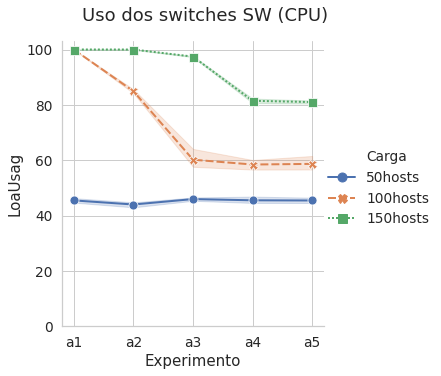

In [6]:
df_sw = df_sw.query("TimeSec > 200 and TimeSec < 400").groupby(["Carga", "Experimento", "Seed"]).mean()
df_sw.reset_index(inplace=True)
snsplt = sns.relplot(x="Experimento", y="LoaUsag",
            hue="Carga",
            kind="line", legend="full", data=df_sw, ci=95, style="Carga", markers=True)
snsplt.fig.suptitle('Uso dos switches SW (CPU)', y=1.05)
snsplt.set(ylim=(0,103))

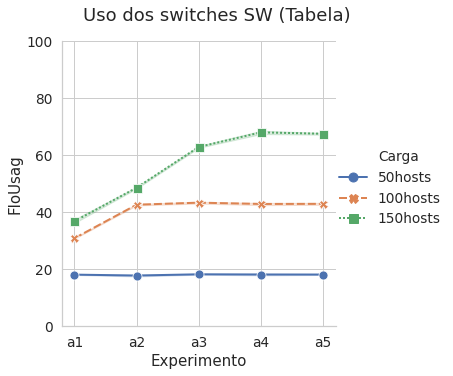

In [7]:
snsplt = sns.relplot(x="Experimento", y="FloUsag",
            hue="Carga",
            kind="line", legend="full", data=df_sw, ci=95, style="Carga", markers=True)
snsplt.fig.suptitle('Uso dos switches SW (Tabela)', y=1.05)
snsplt.set(ylim=(0,100))

In [8]:
df_decisao = read_df_decisao()
df_decisao

SwAtivosAntes  AvgCPULoad  Decisão  \
Carga    Experimento Seed TimeSec                                       
50hosts  a1          1    0.0                  1       0.000  Manteve   
                          15.0                 1       0.166  Manteve   
                          30.0                 1       0.305  Manteve   
                          45.0                 1       0.185  Manteve   
                          60.0                 1       0.591  Manteve   
                          75.0                 1       0.597  Manteve   
                          90.0                 1       0.740  Manteve   
                          105.0                1       0.587  Manteve   
                          120.0                1       0.712  Manteve   
                          135.0                1       0.498  Manteve   
...                                          ...         ...      ...   
150hosts a5          6    1860.0               1       0.000  Manteve   
                          1875.0               1       0.000  Manteve   
                          1890.0               1       0.000  Manteve   
                          1905.0               1       0.000  Manteve   
                          1920.0               1       0.000  Manteve   
                          1935.0               1       0.000  Manteve   
                          1950.0               1       0.000  Manteve   
                          1965.0               1       0.000  Manteve   
                          1980.0               1       0.000  Manteve   
                          1995.0               1       0.000  Manteve   

                                   SwAtivosDepois  
Carga    Experimento Seed TimeSec                  
50hosts  a1          1    0.0                   1  
                          15.0                  1  
                          30.0                  1  
                          45.0                  1  
                          60.0                  1  
                          75.0                  1  
                          90.0                  1  
                          105.0                 1  
                          120.0                 1  
                          135.0                 1  
...                                           ...  
150hosts a5          6    1860.0                1  
                          1875.0                1  
                          1890.0                1  
                          1905.0                1  
                          1920.0                1  
                          1935.0                1  
                          1950.0                1  
                          1965.0                1  
                          1980.0                1  
                          1995.0                1  

[11982 rows x 4 columns]

In [9]:
df_decisao = df_decisao.query("TimeSec > 200 and TimeSec < 400").groupby(["Carga", "Experimento", "Seed"]).mean()
df_decisao.reset_index(inplace=True)
#df_decisao.replace({"Experimento":{"a":1,"b":2,"c":3,"d":4}}, inplace=True)
# df_decisao

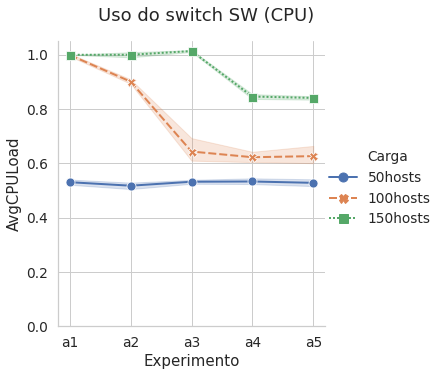

In [10]:
snsplt = sns.relplot(x="Experimento", y="AvgCPULoad",
            hue="Carga",
            kind="line", legend="full", data=df_decisao, ci=95, style="Carga", markers=True)
snsplt.fig.suptitle('Uso do switch SW (CPU)', y=1.05)
snsplt.set(ylim=(0,1.05))

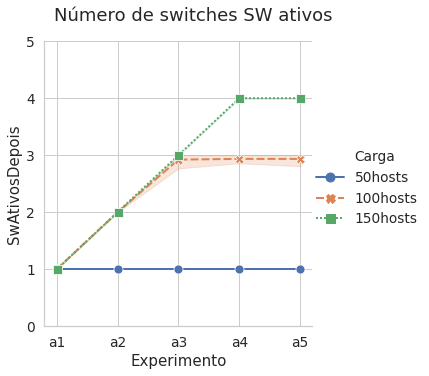

In [11]:
snsplt = sns.relplot(x="Experimento", y="SwAtivosDepois",
            hue="Carga",
            kind="line", legend="full", data=df_decisao, ci=95, style="Carga", markers=True)
snsplt.fig.suptitle('Número de switches SW ativos', y=1.05)
snsplt.set(ylim=(0,5), yticks=(0,1,2,3,4,5))

In [12]:
df_stats = read_df_statistics()
# df_stats.drop(columns=["AvgLoad"], inplace=True)
# df_stats.rename(columns={"SW": "SWAtivos", "Ativos": "AvgLoad"}, inplace=True)
df_stats

RegrasAceitas  RegrasBloqueadas  SWAtivos  \
Carga    Experimento Seed TimeSec                                              
50hosts  a1          1    1.0                  0                 0         1   
                          2.0                 21                 0         1   
                          3.0                 26                 0         1   
                          4.0                 26                 0         1   
                          5.0                 30                 0         1   
                          6.0                 33                 0         1   
                          7.0                 26                 0         1   
                          8.0                 25                 0         1   
                          9.0                 20                 0         1   
                          10.0                26                 0         1   
...                                          ...               ...       ...   
150hosts a5          6    1991.0               0                 0         1   
                          1992.0               0                 0         1   
                          1993.0               0                 0         1   
                          1994.0               0                 0         1   
                          1995.0               0                 0         1   
                          1996.0               0                 0         1   
                          1997.0               0                 0         1   
                          1998.0               0                 0         1   
                          1999.0               0                 0         1   
                          2000.0               0                 0         1   

                                   AvgLoad  
Carga    Experimento Seed TimeSec           
50hosts  a1          1    1.0        0.000  
                          2.0        0.025  
                          3.0        0.065  
                          4.0        0.102  
                          5.0        0.152  
                          6.0        0.203  
                          7.0        0.249  
                          8.0        0.287  
                          9.0        0.318  
                          10.0       0.351  
...                                    ...  
150hosts a5          6    1991.0     0.000  
                          1992.0     0.000  
                          1993.0     0.000  
                          1994.0     0.000  
                          1995.0     0.000  
                          1996.0     0.000  
                          1997.0     0.000  
                          1998.0     0.000  
                          1999.0     0.000  
                          2000.0     0.000  

[180000 rows x 4 columns]

In [13]:
df_stats_bloq = df_stats[["RegrasBloqueadas", "RegrasAceitas"]].query("TimeSec > 200 and TimeSec < 400").groupby(["Carga", "Experimento", "Seed"]).sum()
df_stats_bloq.reset_index(inplace=True)
df_stats_bloq["block"] = df_stats_bloq["RegrasBloqueadas"]/(df_stats_bloq["RegrasAceitas"]+df_stats_bloq["RegrasBloqueadas"])
# df_stats_bloq

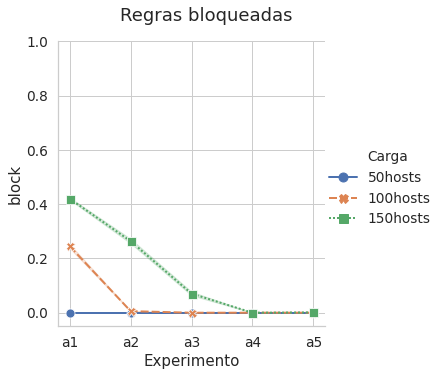

In [14]:
snsplt = sns.relplot(x="Experimento", y="block",
            hue="Carga",
            kind="line", legend="full", data=df_stats_bloq, ci=95, style="Carga", markers=True)
snsplt.fig.suptitle('Regras bloqueadas', y=1.05)
snsplt.set(ylim=(-0.05,1))

In [15]:
df_hw = read_df_hw()
df_hw

LoaKbps  LoaUsag  Packets  DlyUsec  \
Carga    Experimento Seed TimeSec                                       
50hosts  a1          1    1.0        0.000        0        0       34   
                          2.0       17.312        0        2       39   
                          3.0       17.312        0        2       39   
                          4.0       17.312        0        2       39   
                          5.0       17.312        0        2       39   
                          6.0       17.312        0        2       40   
                          7.0       17.312        0        2       40   
                          8.0       17.312        0        2       40   
                          9.0       17.312        0        2       40   
                          10.0      17.312        0        2       40   
...                                    ...      ...      ...      ...   
150hosts a5          6    1991.0    17.312        0        2       40   
                          1992.0    17.312        0        2       40   
                          1993.0    17.312        0        2       40   
                          1994.0    17.312        0        2       40   
                          1995.0    17.312        0        2       40   
                          1996.0    17.312        0        2       40   
                          1997.0    17.312        0        2       40   
                          1998.0    17.312        0        2       40   
                          1999.0    17.312        0        2       40   
                          2000.0     0.000        0        0       40   

                                   LoaDrps  MetDrps  TabDrps  FloMods  \
Carga    Experimento Seed TimeSec                                       
50hosts  a1          1    1.0            0        0        0        3   
                          2.0            0        0        0        0   
                          3.0            0        0        0        0   
                          4.0            0        0        0        0   
                          5.0            0        0        0        0   
                          6.0            0        0        0        0   
                          7.0            0        0        0        0   
                          8.0            0        0        0        0   
                          9.0            0        0        0        0   
                          10.0           0        0        0        0   
...                                    ...      ...      ...      ...   
150hosts a5          6    1991.0         0        0        0        0   
                          1992.0         0        0        0        0   
                          1993.0         0        0        0        0   
                          1994.0         0        0        0        0   
                          1995.0         0        0        0        0   
                          1996.0         0        0        0        0   
                          1997.0         0        0        0        0   
                          1998.0         0        0        0        0   
                          1999.0         0        0        0        0   
                          2000.0         0        0        0        0   

                                   MetMods  GroMods  ...  FloEntr  FloUsag  \
Carga    Experimento Seed TimeSec                    ...                     
50hosts  a1          1    1.0            0        2  ...        3        0   
                          2.0            0        0  ...        3        0   
                          3.0            0        0  ...        3        0   
                          4.0            0        0  ...        3        0   
                          5.0            0        0  ...        3        0   
                          6.0            0        0  ...        3        0   
                          7.0            0        0

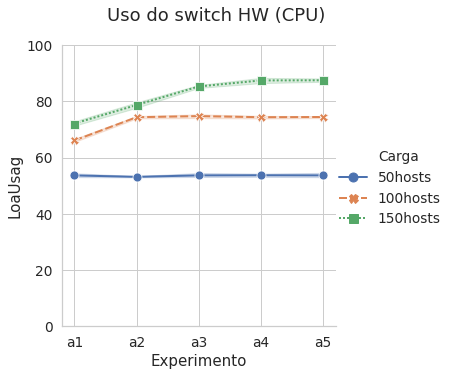

In [16]:
df_hw = df_hw.query("TimeSec > 200 and TimeSec < 400").groupby(["Carga", "Experimento", "Seed"]).mean()
df_hw.reset_index(inplace=True)
# df_hw
snsplt = sns.relplot(x="Experimento", y="LoaUsag",
            hue="Carga",
            kind="line", legend="full", data=df_hw, ci=95, style="Carga", markers=True)
snsplt.fig.suptitle('Uso do switch HW (CPU)', y=1.05)
snsplt.set(ylim=(0,100))

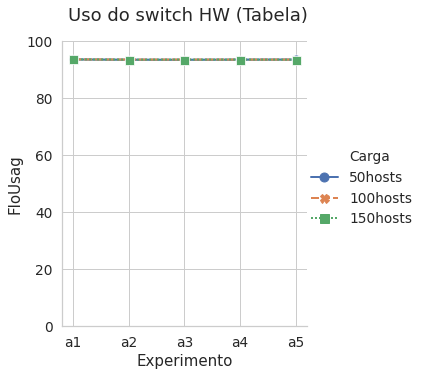

In [17]:
snsplt = sns.relplot(x="Experimento", y="FloUsag",
            hue="Carga",
            kind="line", legend="full", data=df_hw, ci=95, style="Carga", markers=True)
snsplt.fig.suptitle('Uso do switch HW (Tabela)', y=1.05)
snsplt.set(ylim=(0,100))

Text(0.5, 1.05, 'Load drops SW')

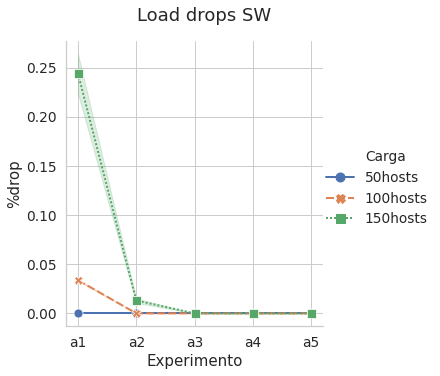

In [18]:
snsplt = sns.relplot(x="Experimento", y="%drop",
            hue="Carga",
            kind="line", legend="full", data=df_sw, ci=95, style="Carga", markers=True)
snsplt.fig.suptitle('Load drops SW', y=1.05)
#snsplt.set(xlim=(0,600))

In [19]:
#Lendo os arquivos de ping
df_pingstats = read_df_ping()
df_pingstats = df_pingstats.query("TimeSec > 200 and TimeSec < 400")
df_pingstats.rename(columns={"time": "Ping"}, inplace=True)
df_pingstats.reset_index(inplace=True)
df_pingstats

,Carga,Experimento,Seed,TimeSec,Ping,Switch
0,50hosts,a1,1,201,1.26692,HW
1,50hosts,a1,1,202,1.26692,HW
2,50hosts,a1,1,203,1.26692,HW
3,50hosts,a1,1,204,1.26692,HW
4,50hosts,a1,1,205,1.26692,HW
5,50hosts,a1,1,206,1.26692,HW
6,50hosts,a1,1,207,1.26819,HW
7,50hosts,a1,1,208,1.26692,HW
8,50hosts,a1,1,209,1.26692,HW
9,50hosts,a1,1,210,1.26692,HW


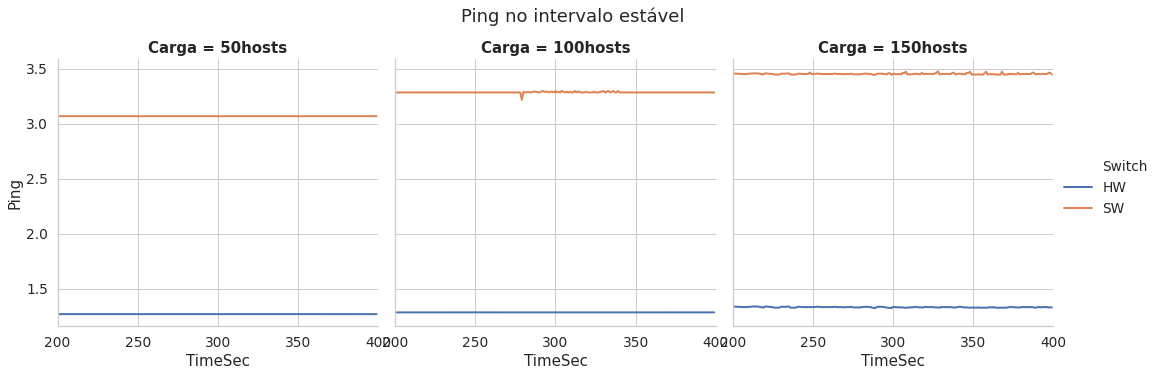

In [20]:
snsplt = sns.relplot(x="TimeSec", y="Ping",
           hue="Switch", col="Carga",
           kind="line", legend="full", data=df_pingstats, ci=None)
snsplt.fig.suptitle('Ping no intervalo estável', y=1.05)
snsplt.set(xlim=(200,400))

In [21]:
df_iperfs = read_df_iperfs()
df_iperfs

Inicio(seg)  Duracao(seg)  Banda(Kbps)   PCli  PServ
50hosts  0            1.064        47.099      327.505  10000  30000
         1            1.094        72.394      392.705  10000  30000
         2            1.114        78.477      981.479  10000  30000
         3            1.122        38.182      150.845  10000  30000
         4            1.195        68.967      478.772  10000  30000
         5            1.201        56.087       89.123  10000  30000
         6            1.221        45.372      962.763  10000  30000
         7            1.225        16.846      770.790  10000  30000
         8            1.269         8.686     1613.628  10000  30000
         9            1.276        98.467      432.608  10001  30001
...                     ...           ...          ...    ...    ...
150hosts 37490      563.889        62.001     1665.084  10246  30246
         37491      565.447        46.461       83.379  10244  30244
         37492      565.747        87.759     1387.698  10245  30245
         37493      566.909        55.304      346.603  10247  30247
         37494      568.859        10.875      897.851  10246  30246
         37495      570.257        46.279      229.376  10248  30248
         37496      571.510        82.910      871.336  10247  30247
         37497      575.007        37.199       39.403  10249  30249
         37498      576.144        18.024      288.215  10248  30248
         37499      576.648        29.695      190.993  10249  30249

[2250000 rows x 5 columns]

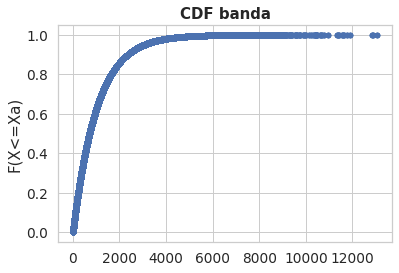

In [22]:
x = np.sort(df_iperfs['Banda(Kbps)'])
y = np.arange(1, len(x)+1) / float(len(x))
grafico = plt.plot(x,y,marker='.', linestyle='none')
grafico = plt.xlabel(u"")
grafico = plt.ylabel("F(X<=Xa)")
grafico = plt.title("CDF banda")
plt.show()

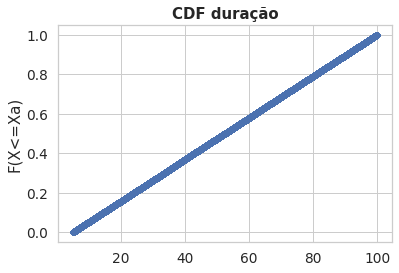

In [23]:
x = np.sort(df_iperfs['Duracao(seg)'])
y = np.arange(1, len(x)+1) / float(len(x))
grafico = plt.plot(x,y,marker='.', linestyle='none')
grafico = plt.xlabel(u"")
grafico = plt.ylabel("F(X<=Xa)")
grafico = plt.title("CDF duração")
plt.show()

In [24]:
df_sw = read_df_sw()
df_sw = df_sw.query("TimeSec > 200 and TimeSec < 400")[["LoaKbps","Packets"]]
df_sw = df_sw.loc[(df_sw["Packets"]!=0)]
df_sw = df_sw.groupby(["Carga", "Experimento", "NumSW", "Seed"]).mean()[["LoaKbps"]]
df_sw = df_sw.groupby(["Carga", "Experimento", "Seed"]).sum()
df_sw = df_sw.rename(columns={"LoaKbps" : "LoaKbpsSW"})
#df_sw.reset_index(inplace = True)

df_hw = read_df_hw()
df_hw = df_hw.query("TimeSec > 200 and TimeSec < 400")[["LoaKbps","Packets"]]
df_hw = df_hw.loc[(df_hw["Packets"]!=0)]
df_hw = df_hw.groupby(["Carga", "Experimento", "Seed"]).mean()[["LoaKbps"]]
df_hw = df_hw.rename(columns={"LoaKbps" : "LoaKbpsHW"})
#df_hw.reset_index(inplace = True)


df_total = pd.concat([df_sw, df_hw], axis=1)
df_total["Soma"] = df_total["LoaKbpsSW"] + df_total["LoaKbpsHW"]
df_total.reset_index(inplace = True)

Text(0.5, 1.05, 'Vazão Agregada Média')

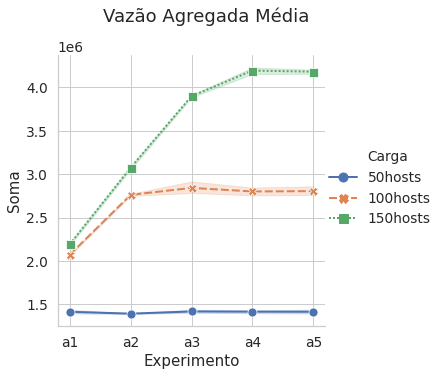

In [25]:
snsplt = sns.relplot(x="Experimento", y="Soma",
            hue="Carga",
            kind="line", legend="full", data=df_total, ci=95, style="Carga", markers=True)
snsplt.fig.suptitle('Vazão Agregada Média', y=1.05)
#snsplt.set(ylim=(0,1.05))"